# gempakIO Examples
Nathan Wendt ([email](mailto:nathan.wendt@noaa.gov)) ([@nawendt](https://www.twitter.com/nawendt))  
Meteorologist  
[NWS SPC](https://www.spc.noaa.gov)

This notebook will expose you to the basic usage of gempakIO and how to load and extract data. To do that, we will go way back to April 3, 1974, the day of the Super Outbreak.

### Imports

In [1]:
import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT, StationPlot
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

from gempakio import GempakGrid, GempakSounding, GempakSurface

### Misc.

In [2]:
def KTOF(T):
    return T * (9/5.) - 459.67

segment1 = colors.LinearSegmentedColormap.from_list('dewpt1', [(.541,.396,.286), (.286,.255,.212), (.592,.569,.498), (1,1,1)], 30)
segment2 = colors.LinearSegmentedColormap.from_list('dewpt2', [(.894,.961,.894), (.035,.298,.035)], 10)
segment3 = colors.LinearSegmentedColormap.from_list('dewpt3', [(.38,.639,.686), (.075,.169,.165)], 5)
segment4 = colors.LinearSegmentedColormap.from_list('dewpt4', [(.404,.42,.612), (.169,.141,.404)], 5)

DEWPT_LEVELS = np.arange(-20,82,2)
DEWPT_COLORS = np.asarray([ segment1(x) for x in np.linspace(0.,1.,segment1.N) ] +
                          [ segment2(x) for x in np.linspace(0.,1.,segment2.N) ] +
                          [ segment3(x) for x in np.linspace(0.,1.,segment3.N) ] +
                          [ segment4(x) for x in np.linspace(0.,1.,segment4.N) ])

DEWPT_CMAP = colors.ListedColormap(DEWPT_COLORS)
DEWPT_CMAP.set_over((.471,.282,.439))
DEWPT_CBTIX = np.arange(-20,90,10)
DEWPT_NORM = colors.BoundaryNorm(DEWPT_LEVELS, DEWPT_CMAP.N)

## Reading Grids

Reading grids, or any data, is fairly straightforward. You need to instantiate the appropriate class and give it the GEMPAK file. For grids, you will need to use the `GempakGrid` class. Here, we use data from an Eta model re-run for the Super Outbreak of 1974. We will extract MLSP and surface dewpoints and plot them.

In [3]:
atmo_grid = GempakGrid('data/eta_740403_1200_f006.grd')

Extracting data is also quite simple. It works similarly to GEMPAK in that you can select a subset of the data. If no subsetting parameters are given, the entire dataset will be decoded and returned. For each matching grid, an `xarray.DataArray` will be returned in a list.

In [4]:
pmsl = atmo_grid.gdxarray(parameter='PMSL')[0]
sfc_dewpt = atmo_grid.gdxarray(parameter='DWPF')[0]

### Plot

In [5]:
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6371200.0, semiminor_axis=6371200.0)

To plot you will need to have the CRS information of the grid. Grids have the CRS information embedded within them as a `pyproj.CRS` object. You can retrieve it as follows:

In [6]:
atmo_grid.crs

<Projected CRS: +proj=lcc +lon_0=-95.0 +lat_1=25.0 +lat_2=25.0 +el ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [7]:
proj = ccrs.LambertConformal(central_longitude=-95.0, standard_parallels=(25.0,25.0), globe=globe)

Geographic coordinates are also created and stored within the `GempakGrid` obect.

In [8]:
lon = atmo_grid.lon
lat = atmo_grid.lat

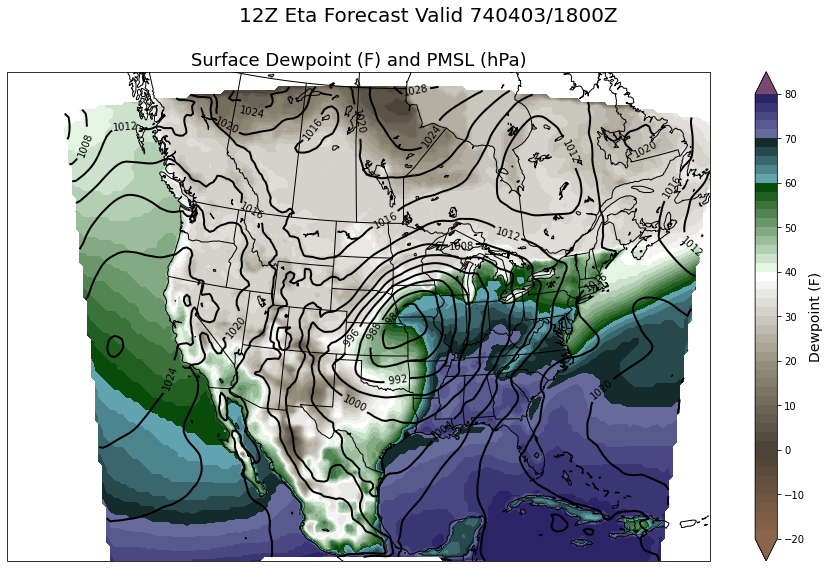

In [9]:
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection=proj)
cbax = ax.contourf(lon, lat, sfc_dewpt[0,0,...], transform = ccrs.PlateCarree(), 
                     cmap=DEWPT_CMAP, norm=DEWPT_NORM, levels=DEWPT_LEVELS, extend='both')
ctax = ax.contour(lon, lat, pmsl[0,0,...], levels = np.arange(980, 1044, 4), 
                  colors = 'k', transform = ccrs.PlateCarree(),
                  linewidths = 2)
plt.clabel(ctax, inline = True, fmt = '%4d')
ax.add_feature(feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.add_feature(feature.NaturalEarthFeature(
        category='physical',
        name='lakes',
        scale='50m',
        facecolor='none',
        edgecolor='black'))
ax.coastlines('50m')
ax.add_feature(feature.BORDERS)
plt.title('Surface Dewpoint (F) and PMSL (hPa)', fontsize=18)
plt.suptitle('12Z Eta Forecast Valid 740403/1800Z', fontsize=20)
cb = plt.colorbar(cbax, ax = ax)
cb.set_label(label='Dewpoint (F)', fontsize=14)
cb.set_ticks(DEWPT_CBTIX)

## Reading Soundings

The `GempakSounding` class is used for vertical profiles. Let's plot a sounding from Nashville, TN from 1 PM CDT on April 3, 1974.

In [10]:
raobs = GempakSounding('data/19740403_upa.snd')

Could not interpret data source `1952805748`. Setting to `Unknown`.


Selecting a station is identical to grids, only with a different set of paramters to use. The resulting matched stations will be returned as a list of `xarray.Dataset`.

In [11]:
bna = raobs.snxarray(station_id='BNA', date_time='197404031800')[0]

In [12]:
hght = bna.hght.values.squeeze() * units.m
p = bna.pres.values * units.hPa
T = bna.tmpc.values.squeeze() * units.degC
Td = bna.dwpc.values.squeeze() * units.degC
wind_speed = bna.sknt.values.squeeze() * units.knots
wind_dir = bna.drct.values.squeeze() * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

### Plot

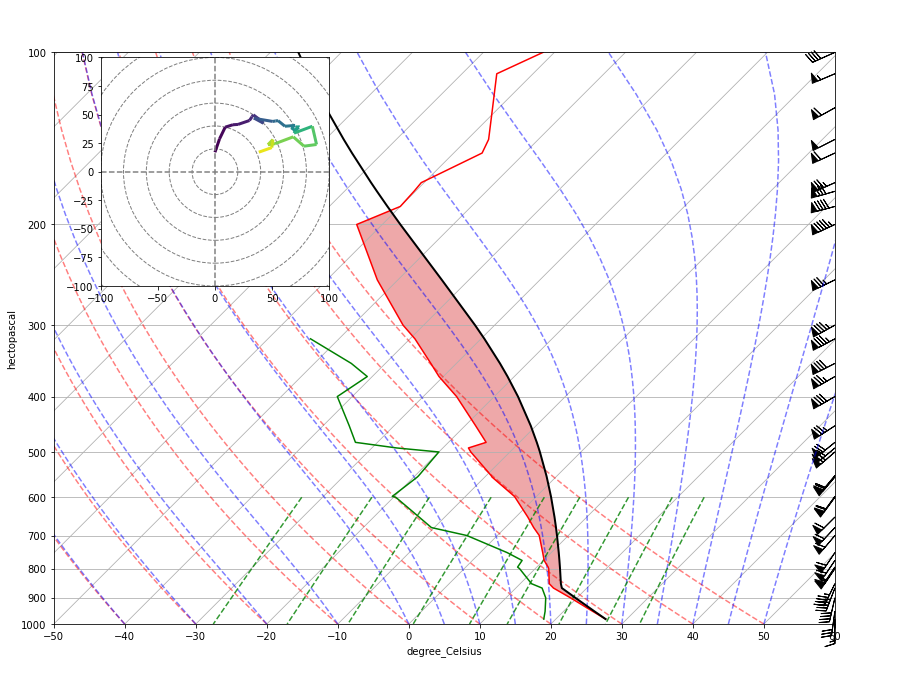

In [13]:
fig = plt.figure(figsize=(14, 14))

skew = SkewT(fig, rotation=45)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_xlim(-50, 60)

# We need to skip the first level as that is a mandatory level that is
# below ground.
prof = mpcalc.parcel_profile(p[1:], T[1], Td[1])
skew.plot(p[1:], prof, 'k', linewidth=2)
skew.shade_cape(p[1:], T[1:], prof)

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=100.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, hght)

## Reading Surface Data

Surface data is read by the `GempakSurface` class. We will load and plot METAR data from 1 PM CDT on April 3, 1974.

In [14]:
metars = GempakSurface('data/19740403_sao.sfc')

As before, the slection process works the same. This is the most likely place to see subsetting. As you will see in the plot, you can have very dense station data in some areas. xarray objects are not used for surface data. Instead, a list of JSON objects (or dictionaries, really) are returned.

In [15]:
us = metars.sfjson(country='US', date_time='197404031800')

Since there are missing pieces of data, denoted by -9999, we set those to NA to avoid plotting.

In [16]:
stn_lon = np.array([stn['properties']['longitude'] for stn in us])
stn_lat = np.array([stn['properties']['latitude'] for stn in us])
stn_T = [KTOF(stn['values']['tmpk']) if stn['values']['tmpk'] != -9999 else np.nan for stn in us]
stn_Td = [KTOF(stn['values']['dwpk']) if stn['values']['dwpk'] != -9999 else np.nan for stn in us]
stn_wdir = np.array([stn['values']['drct'] if stn['values']['drct'] != -9999 else np.nan for stn in us])
bad = stn_wdir > 360
stn_wdir[bad] = np.nan
stn_wspd = np.array([stn['values']['sped'] if stn['values']['sped'] != -9999 else np.nan for stn in us])
stn_wspd[bad] = np.nan
stn_u, stn_v = mpcalc.wind_components(stn_wspd * units.knots,
                                      stn_wdir * units.degrees)
stn_id = np.array([stn['properties']['station_id'] for stn in us])

### Plot

Text(0.5, 1.0, 'Surface Stations -- 1974-04-03 1800Z')

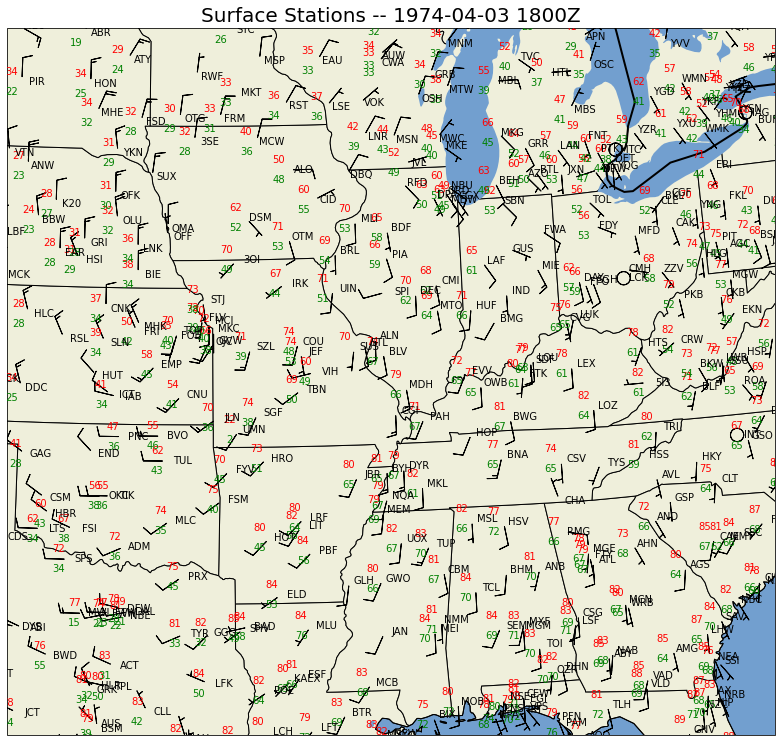

In [17]:
EXTENT = [-100,-80,30,45]
fig = plt.figure(figsize=(20, 13))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.set_facecolor('#729FCF')
ax.coastlines(resolution='50m', zorder=1, color='black')
ax.add_feature(feature.NaturalEarthFeature(category='cultural',
                                            name='admin_1_states_provinces',
                                            scale='50m',
                                            facecolor=feature.COLORS['land'],
                                            edgecolor='black'), zorder=0)
ax.add_feature(feature.NaturalEarthFeature(category='physical',
                                           name='lakes',
                                           scale='50m',
                                           facecolor='#729FCF'), zorder=0)
ax.add_feature(feature.BORDERS, linewidth=2, edgecolor='black', zorder=0)

stationplot = StationPlot(ax, stn_lon, stn_lat, clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)

stationplot.plot_parameter('NW', stn_T, color='red')
stationplot.plot_parameter('SW', stn_Td, color='green')
stationplot.plot_barb(stn_u, stn_v, color = 'black')
stationplot.plot_text((1.5, 0), stn_id)

ax.set_extent(EXTENT, ccrs.PlateCarree())
plt.title('Surface Stations -- 1974-04-03 1800Z', fontsize=20)